# PyTorch Inference Optimizations with Advanced Matrix Extensions Bfloat16 Integer8

This code sample will perform inference on the ResNet50 and BERT models while using Intel® Extension for PyTorch*. For each pretrained model, there will be a warm up of 20 samples before running inference on the specified number of samples (i.e. 1000) to record the time. AMX is supported on BF16 and INT8 data types starting with the 4th Generation of Xeon Scalable Processors. The inference time will be compared, showcasing the speedup over FP32 when using AVX-512, AMX, BF16, and INT8. The following run cases are executed:  

1. FP32 (baseline)
2. BF16 using AVX512_CORE_AMX
3. INT8 using AVX512_CORE_VNNI
4. INT8 using AVX512_CORE_AMX

## Environment Setup

Ensure the PyTorch kernel is activated before running this notebook.

## Imports, Constants

In [1]:
import os
from time import time
import matplotlib.pyplot as plt
import torch
import intel_extension_for_pytorch as ipex
from intel_extension_for_pytorch.quantization import prepare, convert
import torchvision
from torchvision import models
from transformers import BertModel

/home/sdp/anaconda3/envs/a_webinar_TP/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NUM_SAMPLES = 1000   # number of samples to perform inference on
SUPPORTED_MODELS = ["resnet50", "bert"]   # models supported by this code sample

# BERT sample data parameters
BERT_BATCH_SIZE = 1
BERT_SEQ_LENGTH = 512

## Identify Supported ISA  
We identify the underlying supported ISA to determine whether AMX is supported. The 4th Gen Intel® Xeon® Scalable Processor (codenamed Sapphire Rapids) or newer must be used to run this sample.  

In [3]:
# Check if hardware supports AMX
import sys
sys.path.append('../../')
# import version_check
# from cpuinfo import get_cpu_info
# info = get_cpu_info()
# flags = info['flags']
# amx_supported = False
# for flag in flags:
#     if "amx" in flag:
#         amx_supported = True
#         break
# if not amx_supported:
#     print("AMX is not supported on current hardware. Code sample cannot be run.\n")

If the message "AMX is not supported on current hardware. Code sample cannot be run." is printed above, the hardware being used does not support AMX. Therefore, this code sample cannot proceed.

## Running Inference
The function runInference() will perform inference on the selected model, precision, and whether AMX is to be enabled. The environment variable `ONEDNN_MAX_CPU_ISA` is used to enable or disable AMX. For more information, refer to the [oneDNN documentation on CPU Dispatcher Control](https://www.intel.com/content/www/us/en/develop/documentation/onednn-developer-guide-and-reference/top/performance-profiling-and-inspection/cpu-dispatcher-control.html). 

To use BF16 in operations, use the `torch.cpu.amp.autocast()` function to perform forward pass. For INT8, the quantization feature from Intel® Extension for PyTorch* is used to quantize the FP32 model to INT8 before running inference.

Torchscript is also utilized to deploy the model in graph mode instead of imperative mode for faster runtime.

In [4]:
"""
Function to perform inference on Resnet50 and BERT
"""
def runInference(model, data, modelName="resnet50", dataType="FP32", amx=True):
    """
    Input parameters
        model: the PyTorch model object used for inference
        data: a sample input into the model
        modelName: str representing the name of the model, supported values - resnet50, bert
        dataType: str representing the data type for model parameters, supported values - FP32, BF16, INT8
        amx: set to False to disable AMX on BF16, Default: True
    Return value
        inference_time: the time in seconds it takes to perform inference with the model
    """
    
    # Display run case
    if amx:
        isa_text = "AVX512_CORE_AMX"
    else:
        isa_text = "AVX512_CORE_VNNI"
    print("%s %s inference with %s" %(modelName, dataType, isa_text))

    # Configure environment variable
    if not amx:
        os.environ["ONEDNN_MAX_CPU_ISA"] = "AVX512_CORE_VNNI"
    else:
        os.environ["ONEDNN_MAX_CPU_ISA"] = "DEFAULT"

    # Special variables for specific models
    if "bert" == modelName:
        d = torch.randint(model.config.vocab_size, size=[BERT_BATCH_SIZE, BERT_SEQ_LENGTH]) # sample data input for torchscript and inference

    # Prepare model for inference based on precision (FP32, BF16, INT8)
    if "INT8" == dataType:
        # Quantize model to INT8 if needed (one time)
        model_filename = "quantized_model_%s.pt" %modelName
        if not os.path.exists(model_filename):
            qconfig = ipex.quantization.default_static_qconfig
            prepared_model = prepare(model, qconfig, example_inputs=data, inplace=False)
            converted_model = convert(prepared_model)
            with torch.no_grad():
                if "resnet50" == modelName:
                    traced_model = torch.jit.trace(converted_model, data)
                elif "bert" == modelName:
                    traced_model = torch.jit.trace(converted_model, (d,), check_trace=False, strict=False)
                else:
                    raise Exception("ERROR: modelName %s is not supported. Choose from %s" %(modelName, SUPPORTED_MODELS))
                traced_model = torch.jit.freeze(traced_model)
            traced_model.save(model_filename)

        # Load INT8 model for inference
        model = torch.jit.load(model_filename)
        model.eval()
        model = torch.jit.freeze(model)
    elif "BF16" == dataType:
        model = ipex.optimize(model, dtype=torch.bfloat16)
        with torch.no_grad():
            with torch.cpu.amp.autocast():
                if "resnet50" == modelName:
                    model = torch.jit.trace(model, data)
                elif "bert" == modelName:
                    model = torch.jit.trace(model, (d,), check_trace=False, strict=False)
                else:
                    raise Exception("ERROR: modelName %s is not supported. Choose from %s" %(modelName, SUPPORTED_MODELS))
                model = torch.jit.freeze(model)
    else: # FP32
        with torch.no_grad():
            if "resnet50" == modelName:
                model = torch.jit.trace(model, data)
            elif "bert" == modelName:
                model = torch.jit.trace(model, (d,), check_trace=False, strict=False)
            else:
                raise Exception("ERROR: modelName %s is not supported. Choose from %s" %(modelName, SUPPORTED_MODELS))
            model = torch.jit.freeze(model)

    # Run inference
    with torch.no_grad():
        if "BF16" == dataType:
            with torch.cpu.amp.autocast():
                # Warm up
                for i in range(20):
                    model(data)
                
                # Measure latency
                start_time = time()
                for i in range(NUM_SAMPLES):
                    model(data)
                end_time = time()
        else:
            # Warm up
            for i in range(20):
                model(data)
            
            # Measure latency
            start_time = time()
            for i in range(NUM_SAMPLES):
                model(data)
            end_time = time()
    inference_time = end_time - start_time
    print("Inference on %d samples took %.3f seconds" %(NUM_SAMPLES, inference_time))

    return inference_time

The function summarizeResults() displays the inference times and generates one graph for comparing the inference times and another graph for comparing the speedup using FP32 as the baseline.

In [5]:
"""
Prints out results and displays figures summarizing output.
"""
def summarize_results(modelName="", results=None):
    """
    Input parameters
        modelName: a str representing the name of the model
        results: a dict with the run case and its corresponding time in seconds
    Return value
        None
    """

    # Inference time results
    print("\nSummary for %s (%d samples)" %(modelName, NUM_SAMPLES))
    for key in results.keys():
        print("%s inference time: %.3f seconds" %(key, results[key]))

    # Create bar chart with inference time results
    plt.figure()
    plt.title("%s Inference Time (%d samples)" %(modelName, NUM_SAMPLES))
    plt.xlabel("Run Case")
    plt.ylabel("Inference Time (seconds)")
    plt.bar(results.keys(), results.values())

    # Calculate speedup when using AMX
    print("\n")
    bf16_with_amx_speedup = results["FP32"] / results["BF16_with_AMX"]
    print("BF16 with AMX is %.2fX faster than FP32" %bf16_with_amx_speedup)
    int8_with_vnni_speedup = results["FP32"] / results["INT8_with_VNNI"]
    print("INT8 without AMX is %.2fX faster than FP32" %int8_with_vnni_speedup)
    int8_with_amx_speedup = results["FP32"] / results["INT8_with_AMX"]
    print("INT8 with AMX is %.2fX faster than FP32" %int8_with_amx_speedup)
    print("\n\n")

    # Create bar chart with speedup results
    plt.figure()
    plt.title("%s AMX BF16/INT8 Speedup over FP32" %modelName)
    plt.xlabel("Run Case")
    plt.ylabel("Speedup")
    plt.bar(results.keys(), 
        [1, bf16_with_amx_speedup, int8_with_vnni_speedup, int8_with_amx_speedup]
    )

### ResNet50

In [6]:
# Set up ResNet50 model and sample data
resnet_model = models.resnet50(pretrained=True)
resnet_data = torch.rand(1, 3, 224, 224)
resnet_model.eval()

/home/sdp/anaconda3/envs/a_webinar_TP/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sdp/anaconda3/envs/a_webinar_TP/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# FP32 (baseline)
fp32_resnet_inference_time = runInference(resnet_model, resnet_data, modelName="resnet50", dataType="FP32", amx=True)

resnet50 FP32 inference with AVX512_CORE_AMX
Inference on 1000 samples took 15.430 seconds


In [8]:
# BF16 using AMX
bf16_amx_resnet_inference_time = runInference(resnet_model, resnet_data, modelName="resnet50", dataType="BF16", amx=True)

resnet50 BF16 inference with AVX512_CORE_AMX
Inference on 1000 samples took 13.815 seconds


In [9]:
# INT8 using AVX-512
int8_with_vnni_resnet_inference_time = runInference(resnet_model, resnet_data, modelName="resnet50", dataType="INT8", amx=False)

resnet50 INT8 inference with AVX512_CORE_VNNI
Inference on 1000 samples took 1.297 seconds


In [10]:
# INT8 using AMX
int8_amx_resnet_inference_time = runInference(resnet_model, resnet_data, modelName="resnet50", dataType="INT8", amx=True)

resnet50 INT8 inference with AVX512_CORE_AMX
Inference on 1000 samples took 1.291 seconds



Summary for ResNet50 (1000 samples)
FP32 inference time: 15.430 seconds
BF16_with_AMX inference time: 13.815 seconds
INT8_with_VNNI inference time: 1.297 seconds
INT8_with_AMX inference time: 1.291 seconds


BF16 with AMX is 1.12X faster than FP32
INT8 without AMX is 11.89X faster than FP32
INT8 with AMX is 11.95X faster than FP32





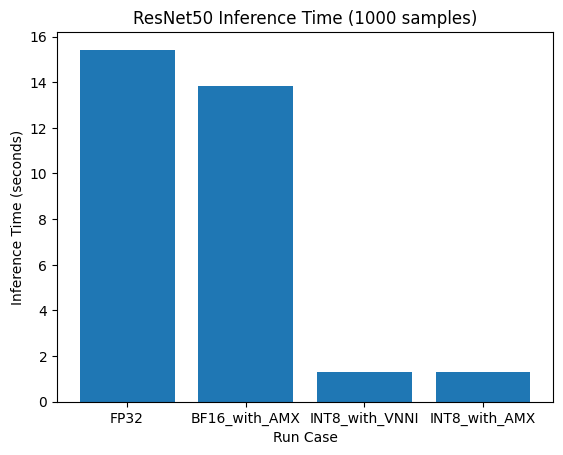

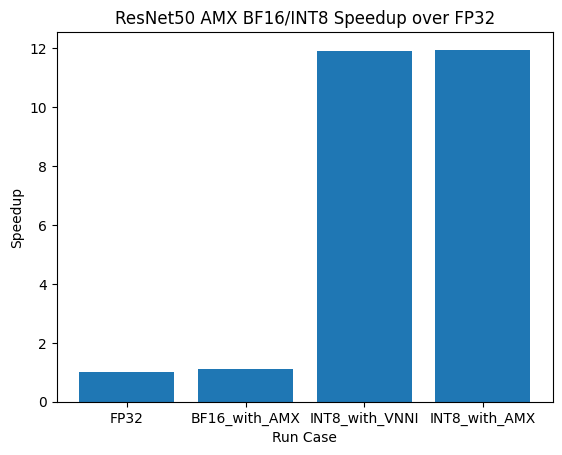

In [11]:
# Summarize and display results
results_resnet = {
        "FP32": fp32_resnet_inference_time,
        "BF16_with_AMX": bf16_amx_resnet_inference_time,
        "INT8_with_VNNI": int8_with_vnni_resnet_inference_time,
        "INT8_with_AMX": int8_amx_resnet_inference_time
    }
summarize_results("ResNet50", results_resnet)
plt.show()

The first graph displays the inference times on the specified number of samples. In general, the times should be decreasing from left to right because using lower precision and with AMX accelerates the computations. The second graph displays the relative speedup of each run case compared to that of FP32. In general the speedup should be increasing from left to right.

### BERT

In [12]:
# Set up BERT model and sample data
bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased') 
bert_data = torch.randint(bert_model.config.vocab_size, size=[BERT_BATCH_SIZE, BERT_SEQ_LENGTH])
bert_model.eval()

/home/sdp/anaconda3/envs/a_webinar_TP/lib/python3.9/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /home/sdp/.cache/torch/hub/main.zip


RuntimeError: Missing dependencies: sentencepiece, sacremoses

In [ ]:
fp32_bert_inference_time = runInference(bert_model, bert_data, modelName="bert", dataType="FP32", amx=True)


In [ ]:
bf16_amx_bert_inference_time = runInference(bert_model, bert_data, modelName="bert", dataType="BF16", amx=True)

In [ ]:
int8_with_vnni_bert_inference_time = runInference(bert_model, bert_data, modelName="bert", dataType="INT8", amx=False)

In [ ]:
int8_amx_bert_inference_time = runInference(bert_model, bert_data, modelName="bert", dataType="INT8", amx=True)

In [ ]:
# Summarize and display results
results_bert = {
        "FP32": fp32_bert_inference_time,
        "BF16_with_AMX": bf16_amx_bert_inference_time,
        "INT8_with_VNNI": int8_with_vnni_bert_inference_time,
        "INT8_with_AMX": int8_amx_bert_inference_time
    }
summarize_results("BERT", results_bert)
plt.show()

The first graph displays the inference times on the specified number of samples. In general, the times should be decreasing from left to right because using lower precision and with AMX accelerates the computations. The second graph displays the relative speedup of each run case compared to that of FP32. In general the speedup should be increasing from left to right.

## Conclusion

This code sample shows how to enable and disable AMX during runtime, as well as the performance improvements using AMX BF16 and INT8 for inference on the ResNet50 and BERT models. Performance will vary based on your hardware and software versions. Larger batch sizes should increase the gap between VNNI and AMX. For even more speedup, consider using the Intel® Extension for PyTorch* [Launch Script](https://intel.github.io/intel-extension-for-pytorch/cpu/latest/tutorials/performance_tuning/launch_script.html). 

In [ ]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')